## Text Summarization

### Description

- #### Split by nums of docs: single-doc summarization, multi-docs summarization ####
- #### Split by doc's language: single-language summarization, multi-languages summarization, cross-language summarization ####

#### Below task will focus on single-language summarization ####

### Metric

- #### Rouge ####
&nbsp;&nbsp;&nbsp;&nbsp;Rouge-1,&nbsp;&nbsp;Rouge-2,&nbsp;&nbsp;Rouge-L\
&nbsp;&nbsp;&nbsp;&nbsp;Based on the 1-gram, 2-gram, LCS(longest commen subset)

- #### example ####
#### original sequence: Today's weather is good &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; generation sequence: Today's sun is good right ####
#### 1-gram: [Today's] [weather] [is] [good] &nbsp;&nbsp;&nbsp;&nbsp; [Today's] [sun] [is] [good] [right] ####
#### 2-gram: [Today's weather] [weather is] [is good] &nbsp;&nbsp;&nbsp;&nbsp; [Today's sun] [sun is] [is good] [good right] ####

- #### Rouge-1: P = 3/4, R = 3/5, F = 2 * P * R / P + R ####
- #### Rouge-2: P = 1/3, R = 1/4, F = 2 * P * R / P + R ####
- #### Rouge-L: P = 3/4, R = 3/5, F = 2 * P * R / P + R ####

### Data format

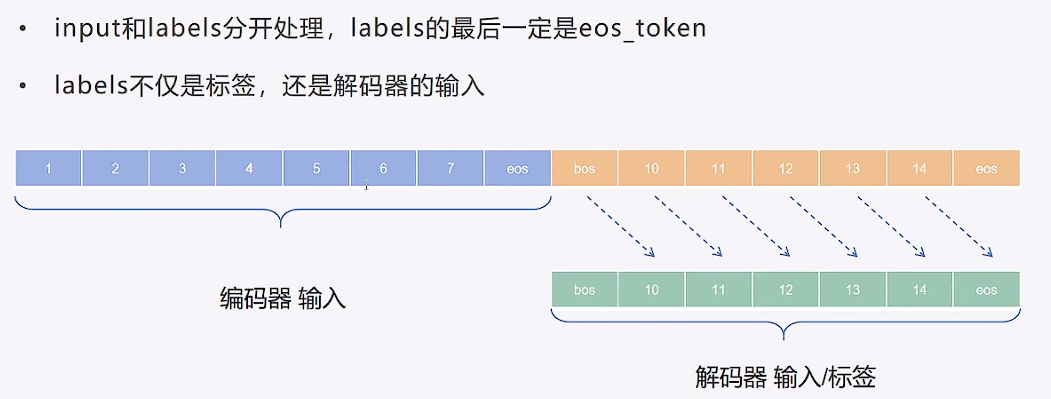

#### Step1 import packs

In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments, pipeline
from datasets import Dataset
import torch
import numpy as np
from rouge_chinese import Rouge

#### Step2 import data

In [5]:
data = Dataset.load_from_disk("./nlpcc_2017")
print(data)
data = data.train_test_split(100, seed=42)
print(data)
print(data["train"][0])

Dataset({
    features: ['title', 'content'],
    num_rows: 5000
})
DatasetDict({
    train: Dataset({
        features: ['title', 'content'],
        num_rows: 4900
    })
    test: Dataset({
        features: ['title', 'content'],
        num_rows: 100
    })
})
{'title': '组图:黑河边防军人零下30℃户外训练,冰霜沾满眉毛和睫毛,防寒服上满是冰霜。', 'content': '中国军网2014-12-1709:08:0412月16日,黑龙江省军区驻黑河某边防团机动步兵连官兵,冒着-30℃严寒气温进行体能训练,挑战极寒,锻造钢筋铁骨。该连素有“世界冠军的摇篮”之称,曾有5人24人次登上世界军事五项冠军的领奖台。(魏建顺摄)黑龙江省军区驻黑河某边防团机动步兵连官兵冒着-30℃严寒气温进行体能训练驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜官兵睫毛上都被冻上了冰霜官兵们睫毛上都被冻上了冰霜驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练'}


#### Step3 data process

In [4]:
tokenizer = T5Tokenizer.from_pretrained("./langboat-mengzi-t5-base")
tokenizer

T5Tokenizer(name_or_path='./langboat-mengzi-t5-base', vocab_size=32128, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '

In [18]:
# for text summarization
def preprocess_func(example, tokenizer=tokenizer):
    content = ["生成文章摘要：" + "\n" + ex for ex in example["content"]]
    inputs = tokenizer(content, max_length=384, truncation=True)
    labels = tokenizer(example["title"], max_length=128, truncation=True)
    inputs["labels"] = labels["input_ids"]

    return inputs

In [19]:
print(tokenizer.eos_token, tokenizer.eos_token_id, "\n", tokenizer.pad_token, tokenizer.pad_token_id)

</s> 1 
 <pad> 0


In [20]:
tokenized_data = data.map(preprocess_func, batched=True, remove_columns=data["train"].column_names)
print(tokenized_data)
print(tokenized_data["train"][0])

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4900
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})
{'input_ids': [5353, 1385, 17965, 13, 5893, 349, 295, 2927, 13049, 114, 1238, 6473, 13, 5844, 13, 6849, 364, 50, 1095, 70, 3, 15059, 12850, 3168, 409, 542, 717, 505, 1139, 877, 20399, 17187, 375, 14061, 3, 18694, 11081, 10788, 722, 24698, 6472, 103, 16773, 1332, 3, 2197, 1164, 1342, 3, 26664, 12966, 789, 1195, 4, 206, 375, 18665, 31, 304, 2808, 5, 24456, 41, 12562, 3, 17222, 108, 21, 1367, 14434, 8768, 304, 2898, 270, 1221, 2808, 5, 1324, 1065, 498, 4, 22, 2962, 606, 1214, 5588, 25, 15059, 12850, 3168, 409, 542, 717, 505, 1139, 877, 20399, 17187, 375, 14061, 18694, 11081, 10788, 722, 24698, 6472, 103, 16773, 1332, 3168, 409, 542, 717, 505, 1139, 877, 20399, 17187, 375, 14061, 24698, 16, 5968, 1332, 3, 1139, 1342, 1163, 23, 586, 11, 1301, 3883, 3168, 4

#### Step4 creat model

In [10]:
t5_sum = T5ForConditionalGeneration.from_pretrained("./langboat-mengzi-t5-base")
print("model imported")

model imported


#### Step5 creat evaluation func

In [22]:
rouge = Rouge()

def compute_eval(pred):
    predictions, labels = pred
    
    # replace padding -100 to pad_token for computing metric
    # Datacollater would automatically padding to max length with -100
    labels = np.where(labels != -100, labels, tokenizer.pad_token)
    
    decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # different from english, zh do not have pad with every vocab
    # so the decoed sentence should concat itself
    decode_predictions = [" ".join(pre) for pre in decode_predictions]
    decode_labels = [" ".join(label) for label in decode_labels]

    scores = rouge.get_scores(decode_predictions, decode_labels, avg=True)

    return {
        "rouge-1":scores["rouge-1"]["f"],
        "rouge-2":scores["rouge-2"]["f"],
        "rouge-l":scores["rouge-l"]["f"]
    }

#### Step6 configration of parameters

In [25]:
train_args = Seq2SeqTrainingArguments(
    output_dir="./text-summarization",
    save_strategy="epoch",
    save_total_limit=3,
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    logging_steps=4, 
    evaluation_strategy="epoch",
    metric_for_best_model="rouge-l",
    predict_with_generate=True, # significant for text2text
)
print(train_args)

Seq2SeqTrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
generation_config=None,
generation_max_length=None,
generation_num_beams=None,
gradient_accumulation_steps=4,
gradient_checkpointing=False,
greater_is_better=Tr

#### Step7 creat trainer

In [ ]:
trainer = Seq2SeqTrainer(
    model=t5_sum,
    args=train_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    compute_metrics=compute_eval,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer)
)

#### Step8 training

In [ ]:
trainer.train()

#### Step9 inference

In [ ]:
pipe = pipeline("text2text-generation", model=t5_sum, tokenizer=tokenizer, device=0)
pipe("生成文章摘要" + "\n" + )